# Segmenting and Clustering Neighborhoods in Toronto

A Jupyter Notebook for the Applied Data Science Capstone, as a part of "IBM Data Science" course on Coursera.

## 1. Scraping Data of Postal Codes and Neighborhoods

In this section we will scrape the Wikipedia page ([List of postal codes of Canada](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)) to extrac neighborhoods in the city of Toronto.In this list corresponds to the postal codes with the first letter M. Postal codes beginning with M are located within the city of Toronto in the province of Ontario.

Then we will convert data to a _pandas_ dataframe by wrangling and cleaning the data.

First of all, we will import necessary libraries.

#### Import necessary libraries

In [229]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium # map rendering library

# Libraries for scraping and communicate with websites
import requests
from bs4 import BeautifulSoup

# File handeling
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

Then we'll use wikipedia page to extrace data of postal codes, boroughs and neighbourhoods. For this purpose we would first extract the page content and make a _soup_ of different elements. Then based on the type of our element, here _table_ and its _class_, here _wikitable sortable_, we would extract the table contents.

In [48]:
# scrap data from wikipedia page
url_wiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page_wiki = requests.get(url_wiki).text
soup = BeautifulSoup(page_wiki, 'lxml')

# get right table to scrap
table = soup.find('table',{'class':'wikitable sortable'})

The content is still not clean and we have our data between lots of `<th> ... <\th>`, `<tr> ... <\tr>`, and `<td> ... <\td>`. We would use `.find` and `.find_all` methods to find these parts and select only the text part. 

In [75]:
# extract header of the table
header = [th.text.rstrip() for th in table.find_all('th')]
header

['Postal Code', 'Borough', 'Neighbourhood']

In [76]:
# extract cells of the table
# consider an empty list for each column of the table
postal_code = []
borough = []
neighbourhood = []

for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells)==3:    # only extract table body not the heading
        postal_code.append(cells[0].find(text=True).rstrip())
        borough.append(cells[1].find(text=True).rstrip())
        neighbourhood.append(cells[2].find(text=True).rstrip())

In the next step we will make our datafram from the extracted `postal_code`, `borough`, `neighbourhood`, which were as `list`. We will use `header` for the column's names.

In [77]:
# make a dataframe of the table
toronto_data = pd.DataFrame(zip(postal_code, borough, neighbourhood), columns = header)
toronto_data

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In the next step we will remove rows which their `Borough`s value is `Not assigned`, and we'll make sure to reset the indecies.

In [78]:
# drop rows which Borough not assigned
toronto_data.drop(toronto_data.index[toronto_data['Borough']=='Not assigned'], inplace=True)
# reset index
toronto_data.reset_index(drop=True, inplace=True)
toronto_data

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Check if there is any `Not assigned` value after cleaning the dataframe or not.

In [79]:
'Not assigned' in toronto_data.Neighbourhood.values

False

We are done for this step as there is no `Not assigned` value for the `Neighbourhood` in the `toronto_data`.

In [80]:
toronto_data.shape

(103, 3)

## 2. Add Location Information (Latitude, Longitude)

In this part we will load a `.csv` file contains postal code of Toronto and corresponding geospatial coordinate.

In [81]:
# load geospatial coordinate file
toronto_geo_coor = pd.read_csv('Torento_Geospatial_Coordinates.csv')
toronto_geo_coor

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


Now we can merge `toronto_geo_coor` and `toronto_data` dataframes together based on `Postal Code` column and then sort it.

In [82]:
toronto_data = pd.merge(toronto_data, toronto_geo_coor, on='Postal Code')
toronto_data.sort_values(by=['Postal Code'], inplace=True)
toronto_data.reset_index(drop=True, inplace=True)
toronto_data

    Postal Code      Borough  \
0           M1B  Scarborough   
1           M1C  Scarborough   
2           M1E  Scarborough   
3           M1G  Scarborough   
4           M1H  Scarborough   
..          ...          ...   
98          M9N         York   
99          M9P    Etobicoke   
100         M9R    Etobicoke   
101         M9V    Etobicoke   
102         M9W    Etobicoke   

                                         Neighbourhood   Latitude  Longitude  
0                                       Malvern, Rouge  43.806686 -79.194353  
1               Rouge Hill, Port Union, Highland Creek  43.784535 -79.160497  
2                    Guildwood, Morningside, West Hill  43.763573 -79.188711  
3                                               Woburn  43.770992 -79.216917  
4                                            Cedarbrae  43.773136 -79.239476  
..                                                 ...        ...        ...  
98                                              Weston  43.706

## 3. Explore and cluster the neighborhoods in Toronto

In this section we will use Foursquare API to explore neighborhoods in Toronto and find out the most common venue categories in each neighborhood. We'll use different features to group the neighborhoods into clusters by use of the k-means clustering algorithm.

First of all we want to create a map of Toronto with neighborhoods superimposed on top.

In [86]:
# create map of Toronto using latitude and longitude values
toronto_latitude = 43.741
toronto_longitude = -79.373

map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough']):
    label = borough
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now we can visualize the map of Downtown and its corresponding neighborhoods.

#### Utilizing the Foursquare API to explore the neighborhoods and segment them

In [103]:
# Define Foursquare Credentials and Version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Explore neighborhoods in Toronto

We know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [104]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [230]:
toronto_venues = getNearbyVenues(toronto_data['Neighbourhood'],
                                   toronto_data['Latitude'],
                                   toronto_data['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

KeyError: 'groups'

Let's check the size of the resulting dataframe:

In [108]:
print(toronto_venues.shape)
toronto_venues.head()

(2129, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank


Let's check the first 20 top venue categories and their numbers:

In [231]:
toronto_venues['Venue Category'].value_counts()[0:20]

Coffee Shop             183
Café                     93
Restaurant               63
Pizza Place              55
Park                     54
Italian Restaurant       44
Hotel                    42
Bakery                   42
Sandwich Place           41
Japanese Restaurant      40
Clothing Store           33
Sushi Restaurant         32
Gym                      31
Fast Food Restaurant     29
Grocery Store            29
Bar                      28
American Restaurant      26
Bank                     25
Seafood Restaurant       23
Thai Restaurant          22
Name: Venue Category, dtype: int64

Number of unique categories:

In [129]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


Now let's groupby by neighborhoods:

In [232]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale East",35,35,35,35,35,35
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,3,3,3,3,3,3


### Analyze each neighborhood

In [150]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
idx = toronto_onehot.columns.get_loc('Neighborhood') # index of 'Neighborhood' column
fixed_columns = [toronto_onehot.columns[idx]] + list(toronto_onehot.columns[:idx]) + list(toronto_onehot.columns[idx+1:])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Let's check the dataframe size:

In [151]:
toronto_onehot.shape

(2129, 271)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [233]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.

First, let's write a function to sort the venues in descending order.

In [153]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [155]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [156]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Clothing Store,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Frozen Yogurt Shop,Bridal Shop,Sandwich Place,Diner,Restaurant,Deli / Bodega,Middle Eastern Restaurant
3,Bayview Village,Café,Bank,Japanese Restaurant,Chinese Restaurant,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Thai Restaurant,Pizza Place,Juice Bar,Café,Indian Restaurant,Pub,Sushi Restaurant


### Clustering neighborhoods

As we want to use _k_-means method for clustering, we have to determine the optimum number of cluster. For this purpose, we use two different methods and use the average of suggested optimal number of clusters:

#### Elbow Method for K means

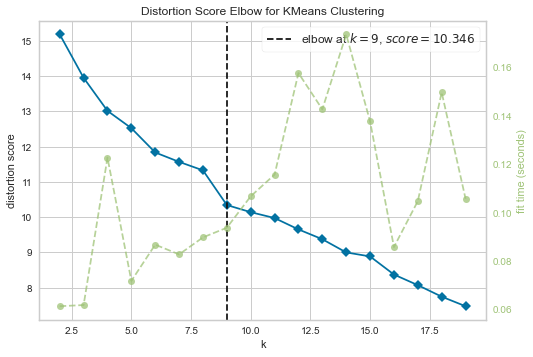

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [187]:
# Remove Neighborhood columns and prepare dataframe for clustering
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',1)

# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(toronto_grouped_clustering)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

#### Silhouette Score for K means

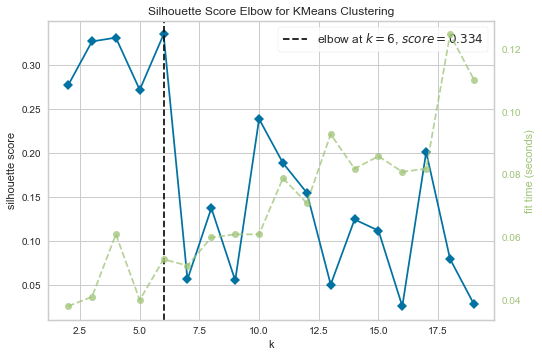

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [197]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The point about all of these methods is that we should run them couple of times and then average over suggested number of clusters. 

Now we will go for clustering with 7 based on the above results.

In [227]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 5, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0,
       1, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2,
       0, 1, 0, 1, 0, 0, 0, 0, 1])

In [234]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
toronto_merged = toronto_merged.dropna()
toronto_merged # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2.0,Fast Food Restaurant,Print Shop,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,Bar,Construction & Landscaping,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Mexican Restaurant,Restaurant,Rental Car Location,Breakfast Spot,Intersection,Bank,Medical Center,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Bank,Hakka Restaurant,Fried Chicken Joint,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Discount Store,Dim Sum Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188,1.0,Park,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,0.0,Pizza Place,Chinese Restaurant,Intersection,Coffee Shop,Sandwich Place,Middle Eastern Restaurant,Discount Store,Yoga Studio,Dim Sum Restaurant,Diner
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,0.0,Park,Mobile Phone Shop,Bus Line,Sandwich Place,Discount Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Escape Room
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,0.0,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Beer Store,Sandwich Place,Japanese Restaurant,Discount Store,Liquor Store,Pharmacy,Pizza Place


In [220]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

End.